In [ ]:
"""
SELECT c.username, c.team, a.level_index, a.score, b.matrix
  FROM leaderboards AS a
  JOIN playthroughs AS b ON a.play_id=b.play_id
  JOIN players AS c ON a.username=c.username
  INTO OUTFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/graphs.txt';
"""

In [87]:
import pandas as pd
import networkx as nx
import seaborn as sns
import s_gd2
import numpy as np
import matplotlib.pyplot as plt
import math

In [15]:
rows = []
with open('graphs.txt') as f:
    for line in f:
        name,team,lid,score,matrix = line.split('\t')
        team = int(team)
        lid = int(lid)
        score = int(score)
        
        rows.append([name,team,lid,score,matrix])
        
df = pd.DataFrame(rows, columns=['username','team','lid','score','matrix'])
df.head()

,username,team,lid,score,matrix
0,135Mallos,0,1,0,\n
1,135Mallos,0,2,1003,"-3.16228e-003,-1.21507e-003;2.43014e-004,-3.16..."
2,135Mallos,0,3,1931,"-3.16228e-003,-1.25055e-005,0.00000e+000;2.501..."
3,135Mallos,0,4,2896,"-3.16228e-003,-5.00727e-006,0.00000e+000,0.000..."
4,135Mallos,0,5,1010,"-3.16228e-003,-1.94805e-004,-1.21507e-003;3.89..."


In [160]:
r0 = 1.71e-6
z0 = 4.15e-8
beta = .75
kgmin = 1e-3
kgmax = 1e3
aiimin = 1e-4
aiimax = 1e-1

def unnormalise(val, minval, maxval):
    logmin = math.log(minval)
    logmax = math.log(maxval)
    logval = math.log(val)
    return (logval - logmin) / (logmax - logmin)

animalcol = {
    (0,0):(0.6659563,0.4214357,1.24803),
    (0,0.25):(0.7819285,0.4702366,1.06561),
    (0,0.5):(0.8521745,0.5083723,0.8867291),
    (0,0.75):(0.8935105,0.5390537,0.710595),
    (0,1):(0.9141396,0.5642439,0.5348938),
    (0.125,0):(0.5896031,0.3516085,1.173094),
    (0.125,0.25):(0.7112292,0.4047686,0.9933422),
    (0.125,0.5):(0.7822568,0.4448652,0.8174194),
    (0.125,0.75):(0.8226988,0.4763547,0.6445394),
    (0.125,1):(0.8417238,0.5017385,0.4721891),
    (0.25,0):(0.5123212,0.2794313,1.098962),
    (0.25,0.25):(0.6412622,0.3392173,0.9219785),
    (0.25,0.5):(0.7132986,0.3820548,0.7491495),
    (0.25,0.75):(0.7528048,0.4146542,0.5797082),
    (0.25,1):(0.7701209,0.4403447,0.4109138),
    (0.375,0):(0.433181,0.2015954,1.02566),
    (0.375,0.25):(0.5719827,0.2728352,0.851553),
    (0.375,0.5):(0.6453318,0.319745,0.6819677),
    (0.375,0.75):(0.6838571,0.353921,0.516175),
    (0.375,1):(0.6993466,0.3800876,0.3511725),
    (0.5,0):(0.3503708,0.1061697,0.9532181),
    (0.5,0.25):(0.503309,0.2039402,0.7821031),
    (0.5,0.5):(0.5783888,0.2575291,0.6159276),
    (0.5,0.75):(0.6158853,0.2940635,0.4540248),
    (0.5,1):(0.629415,0.3209733,0.2930891),
    (0.625,0):(0.2596542,0,0.8816665),
    (0.625,0.25):(0.4350924,0.1276332,0.7136698),
    (0.625,0.5):(0.5125013,0.1944913,0.551089),
    (0.625,0.75):(0.5489184,0.2348568,0.3933562),
    (0.625,1):(0.5603369,0.2629642,0.2368113),
    (0.75,0):(0.1462514,0,0.8110411),
    (0.75,0.25):(0.3670615,0.01534454,0.6462989),
    (0.75,0.5):(0.4476985,0.1281543,0.4875197),
    (0.75,0.75):(0.4829848,0.1757512,0.3342867),
    (0.75,1):(0.4921196,0.2059198,0.182519),
    (0.875,0):(0,0,0.7413815),
    (0.875,0.25):(0.2986907,0,0.5800419),
    (0.875,0.5):(0.384003,0.04765813,0.4252967),
    (0.875,0.75):(0.4181094,0.1152187,0.2769579),
    (0.875,1):(0.4247632,0.149432,0.1304326),
    (1,0):(0,0,0.6727336),
    (1,0.25):(0.2288503,0,0.5149575),
    (1,0.5):(0.3214228,0,0.364509),
    (1,0.75):(0.3543108,0.04708795,0.2215445),
    (1,1):(0.3582592,0.09223427,0.08081748),
}

plantcol = {
    (0,0):(0.2713417,0.8473476,0.6985413),
    (0,0.25):(0.5222976,0.8314039,0.5983568),
    (0,0.5):(0.6702517,0.8133132,0.4962752),
    (0,0.75):(0.7831645,0.7929001,0.3894677),
    (0,1):(0.8772926,0.7699422,0.2702902),
    (0.125,0):(0.1684624,0.7797177,0.6326398),
    (0.125,0.25):(0.4552579,0.7644312,0.5338795),
    (0.125,0.5):(0.6031148,0.7469373,0.4327791),
    (0.125,0.75):(0.7132894,0.7270474,0.3255313),
    (0.125,1):(0.804257,0.7045187,0.1998102),
    (0.25,0):(0,0.7130001,0.5679671),
    (0.25,0.25):(0.388663,0.6984147,0.4706705),
    (0.25,0.5):(0.5370029,0.6815584,0.3704278),
    (0.25,0.75):(0.6443356,0.6622278,0.2618447),
    (0.25,1):(0.7320064,0.6401571,0.1213466),
    (0.375,0):(0,0.6472268,0.5045964),
    (0.375,0.25):(0.3221455,0.6333928,0.4087968),
    (0.375,0.5):(0.4719303,0.6172208,0.3091882),
    (0.375,0.75):(0.576326,0.5984914,0.1975334),
    (0.375,1):(0.6605623,0.5769123,0.003715212),
    (0.5,0):(0,0.5824318,0.4426121),
    (0.5,0.25):(0.2549465,0.5694063,0.3483288),
    (0.5,0.5):(0.4078946,0.5539731,0.2489414),
    (0.5,0.75):(0.5092819,0.5358946,0.1302067),
    (0.5,1):(0.5899497,0.5148475,0),
    (0.625,0):(0,0.5186502,0.3821121),
    (0.625,0.25):(0.1852674,0.5064998,0.2893357),
    (0.625,0.5):(0.3448606,0.491869,0.1893597),
    (0.625,0.75):(0.4432206,0.4745005,0.04941796),
    (0.625,1):(0.5202019,0.4540356,0),
    (0.75,0):(0,0.4559185,0.3232112),
    (0.75,0.25):(0.1073859,0.4447205,0.2318735),
    (0.75,0.5):(0.2827248,0.430968,0.129521),
    (0.75,0.75):(0.3781526,0.414382,0),
    (0.75,1):(0.4516689,0.3945923,0),
    (0.875,0):(0,0.394273,0.2660466),
    (0.875,0.25):(0,0.3841186,0.1759491),
    (0.875,0.5):(0.2212297,0.371336,0.0661454),
    (0.875,0.75):(0.3141779,0.3556307,0),
    (0.875,1):(0.3864371,0.3368182,0),
    (1,0):(0,0.3337484,0.2107842),
    (1,0.25):(0,0.3247465,0.1214123),
    (1,0.5):(0.1597211,0.3130468,0),
    (1,0.75):(0.254261,0.2985509,0),
    (1,1):(0.3258368,0.2809587,0),
}
def clamp(rgb):
    return ( min(max(rgb[0],0),1), min(max(rgb[1],0),1), min(max(rgb[2],0),1) )

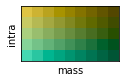

In [363]:
im = np.empty((5,9,3))
for i in range(9):
    size= i/8
    for j in range(5):
        intra = 1-j/4
        im[j,i] = clamp(plantcol[size,intra])

fig,ax = plt.subplots(figsize=(2,1))
# ax.set_xticklabels(np.arange(0,10))
# ax.set_yticklabels(np.arange(6,0,-1))
ax.tick_params(axis='y', left=False, labelleft=False)
ax.tick_params(axis='x', bottom=False, labelbottom=False)
ax.set_xlabel('mass')
ax.set_ylabel('intra')
ax.imshow(im)
plt.savefig('results/plantlab.svg')

In [166]:
def get_nx_from_matrix(matrix):
    A,b,x = matrix.split(':')

    plants = {}
    sizes = {}
    for row, datum in enumerate(b.split(',')):
        val = float(datum)
        if val < 0:
            plants[row] = True
            kg = (-val/r0) ** (1/(beta-1))
        else:
            plants[row] = False
            kg = (val/z0) ** (1/(beta-1))

        sizes[row] = round(unnormalise(kg, kgmin, kgmax), 4)

    intras = {}
    inters = {}
    G = nx.DiGraph()
    for row, data in enumerate(A.split(';')):
        for col, datum in enumerate(data.split(',')):
            val = float(datum)
            if row == col:
                intras[row] = round(unnormalise(-val, aiimin, aiimax), 4)
            elif val != 0:
                if val<0:
                    G.add_edge(row,col)
                inters[(row,col)] = val
                
    nx.set_node_attributes(G, plants, 'plant')
    nx.set_node_attributes(G, sizes, 'size')
    nx.set_node_attributes(G, intras, 'intra')
    nx.set_edge_attributes(G, inters, 'inter')

    colors = {}
    for idx in plants.keys():
        if plants[idx]:
            colors[idx] = clamp(plantcol[sizes[idx],intras[idx]])
        else:
            colors[idx] = clamp(animalcol[sizes[idx],intras[idx]])    
    nx.set_node_attributes(G, colors, 'color')
    
    return G

done 2 0
done 3 0
done 4 0
done 5 0
done 6 0
done 7 0
done 8 0
done 9 0
done 10 0
done 11 0
done 12 0
done 13 0
done 14 0
done 15 0
done 16 0
done 17 0
done 18 0
done 101 0
done 101 1
done 101 2
done 102 0
done 102 1
done 102 2
done 103 0
done 103 1
done 103 2


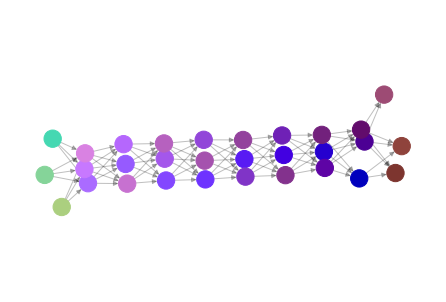

In [345]:
# draw graphs

lid_grouped = df.groupby('lid')

for lid in lid_grouped.groups.keys():        
    df_lid = lid_grouped.get_group(lid)
    df_best = df_lid.sort_values('score', ascending=False) # only take first playthrough
    
    nranks = 3 if lid > 100 else 1 if lid > 1 else 0
    for rank in range(nranks):
        matrix = df_best.iloc[rank]['matrix']
        G = get_nx_from_matrix(matrix)

        I,J = zip(*G.edges)
        X = s_gd2.layout(I,J)
        
        cols = nx.get_node_attributes(G, 'color')
        nodelist = G.nodes
        colors = [cols[i] for i in nodelist]

        plt.clf()
        nx.draw(G, nodelist=nodelist, pos=X, node_color=colors, edge_color=(0,0,0,.25))
        plt.axis('equal')
        plt.savefig(f'results/nodelinks/{lid}_{rank}.png')
        print(f'done {lid} {rank}')

In [238]:
def graph_attrs(G):
    n = len(G)
    L = np.zeros((n,n))
    C = 0
    for e in G.edges:
        res = e[0]
        con = e[1]
        L[con,con] += 1
        L[con,res] -= 1
        C += 1
    
    attrs = {}
    C /= (n*(n-1)) / 2
    attrs['connectance'] = C
        
    for row in range(n):
        if L[row,row] == 0:
            L[row,row] = 1;
        else:
            L[row] /= L[row,row]
            
    b = np.ones(n)
    levels = np.linalg.solve(L, b)
    trophic = {}
    for i in range(n):
        trophic[i] = levels[i]
        
    coherence = 0
    for e in G.edges:
        res = e[0]
        con = e[1]
        coherence += (trophic[res]-trophic[con]) ** 2
    coherence /= len(G.edges)
    coherence = np.sqrt(coherence-1)
    attrs['incoherence'] = coherence
        
    nx.set_node_attributes(G, trophic, 'trophic')
    
    undirected = nx.Graph(G.edges)
#     communities = nx.algorithms.community.greedy_modularity_communities(undirected)
#     communities = list(communities)
    return attrs

In [308]:
G = nx.DiGraph()
G.add_edge(0,1)
G.add_edge(0,2)
print(graph_attrs(G))

{'connectance': 0.6666666666666666, 'incoherence': 0.0}


doing 101
LeickR 1
Derek 1
manusacco 0
doing 102
cjddig 1
Fran 0
Sue10 1
doing 103
Derek 1
alexd81 0
juan1602 0


/home/jz/.local/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in sqrt


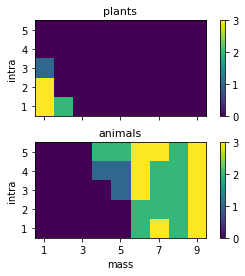

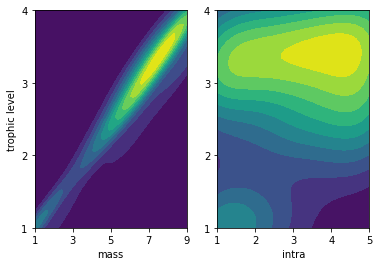

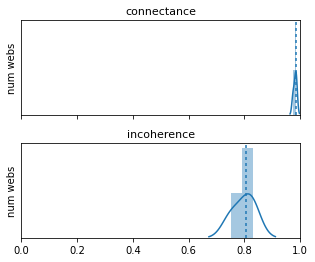

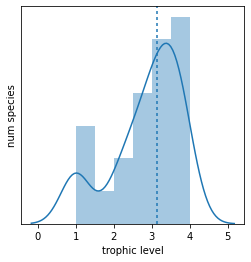

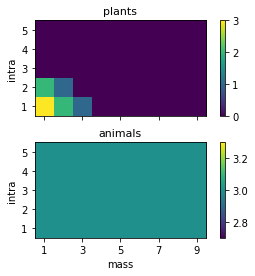

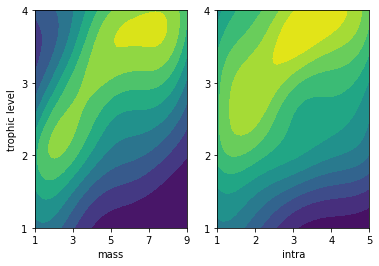

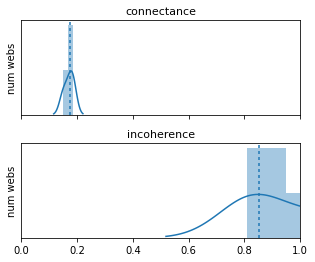

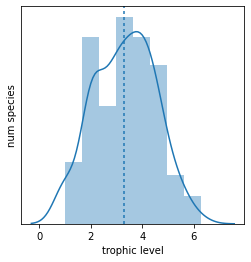

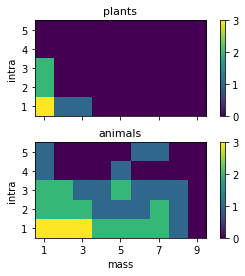

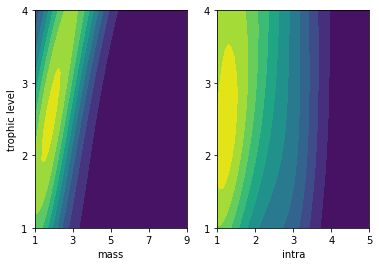

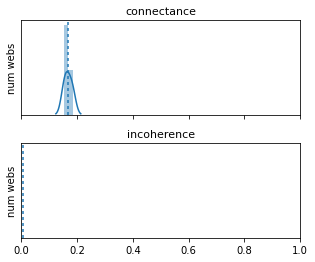

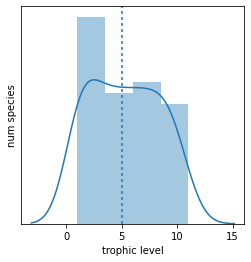

In [357]:
lid_grouped = df.groupby('lid')

for lid in lid_grouped.groups.keys():
    if lid<100:
        continue
    print(f'doing {lid}')
        
    df_lid = lid_grouped.get_group(lid)
    df_best = df_lid.sort_values('score', ascending=False) # only take first playthrough

    im_anim = np.zeros((5,9))
    im_plant = np.zeros((5,9))
    
    x_trophic = []
    y_size = []
    y_intra = []
    
    connectances = []
    coherences = []
    
    nranks = 3
#     nranks = len(df_best)
    for rank in range(nranks):
        row = df_best.iloc[rank]
        print(row['username'], row['team'])
        try:
            G = get_nx_from_matrix(row['matrix'])
        except ValueError:
            print(f'bad data in {row["username"]}')
            continue
        
        attrs = graph_attrs(G)
        trophics = nx.get_node_attributes(G, 'trophic')
            
        sizes = nx.get_node_attributes(G, 'size')
        intras = nx.get_node_attributes(G, 'intra')
        plants = nx.get_node_attributes(G, 'plant')
        
        for idx in sizes.keys():
            col = int(sizes[idx]*8)
            row = 4-int(intras[idx]*4)
            if plants[idx]:
                im_plant[row,col] += 1
            else:
                im_anim[row,col] += 1

            x_trophic.append(trophics[idx])
            y_size.append(sizes[idx])
            y_intra.append(intras[idx])
        
        connectances.append(attrs['connectance'])
        if not math.isnan(attrs['incoherence']):
            coherences.append(attrs['incoherence'])
    
    #######################
    # SIZE AGAINST INTRA
    
    fig,axes = plt.subplots(nrows=2, gridspec_kw={'hspace':.28}, figsize=(5,4))
    
    viridis = plt.get_cmap('viridis')
    tab10 = plt.get_cmap('tab10')
    
    axes[0].set_title('plants', fontsize=11)
    axes[0].tick_params(axis='x', labelbottom=False)
#     axes[0].set_xticks(np.arange(0,9))
#     axes[0].set_xticklabels(np.arange(1,10))
    axes[0].set_yticks(np.arange(0,6))
    axes[0].set_yticklabels(np.arange(5,0,-1))
#     axes[0].set_xlabel('mass')
    axes[0].set_ylabel('intra')
    a = axes[0].imshow(im_plant)
    
    axes[1].set_title('animals', fontsize=11)
    axes[1].set_xticks(np.arange(0,9,2))
    axes[1].set_xticklabels(np.arange(1,10,2))
    axes[1].set_yticks(np.arange(0,6))
    axes[1].set_yticklabels(np.arange(5,0,-1))
    axes[1].set_xlabel('mass')
    axes[1].set_ylabel('intra')
    b = axes[1].imshow(im_anim)
    
    colora = plt.colorbar(a, ax=axes[0])
    colorb = plt.colorbar(b, ax=axes[1])
    
    plt.savefig(f'results/research/{lid}_{nranks}_0.svg')
    
    
    ##############################
    # TROPHIC AGAINST MASS/INTRA
    
    fig,axes = plt.subplots(ncols=2, figsize=(6,4))
    sns.kdeplot(y_size, x_trophic, shade=True, ax=axes[0], cmap=viridis)
    sns.kdeplot(y_intra, x_trophic, shade=True, ax=axes[1], cmap=viridis)#, bw=.4)
#     sns.scatterplot(y_size, x_trophic, ax=axes[0])
#     sns.scatterplot(y_intra, x_trophic, ax=axes[1])
    axes[0].set_ylabel('trophic level')
    axes[0].set_yticks([1,2,3,4])
    axes[0].set_xlabel('mass')
    axes[0].set_xlim([0,1])
    axes[0].set_ylim([1,4])
    axes[0].set_xticks([0,.25,.5,.75,1])
    axes[0].set_xticklabels([1,3,5,7,9])
    
    axes[1].set_yticks([1,2,3,4])
    axes[1].set_xlabel('intra')
    axes[1].set_xlim([0,1])
    axes[1].set_ylim([1,4])
    axes[1].set_xticks([0,.25,.5,.75,1])
    axes[1].set_xticklabels([1,2,3,4,5])
    
    plt.savefig(f'results/research/{lid}_{nranks}_1.svg')
    
    
    ##############################
    # CONNECTANCE AND INCOHERENCE
    
    # compare trophic level against size
    fig,axes = plt.subplots(nrows=2, figsize=(5,4), gridspec_kw={'hspace':.3})
    med_conn = np.median(connectances)
    med_cohe = np.median(coherences)
    sns.distplot(connectances, ax=axes[0], color=tab10(0))
    axes[0].axvline(med_conn, ls=(0,[2,2]), color=tab10(0))
    axes[0].set_title('connectance', fontsize=11)
    axes[0].set_xlim([0,1])
    axes[0].tick_params(axis='x', labelbottom=False)
    axes[0].set_ylabel('num webs')
    axes[0].tick_params(axis='y', left=False, labelleft=False)
    
    axes[1].set_title('incoherence', fontsize=11)
    axes[1].set_xlim([0,1])
    axes[1].set_ylabel('num webs')
    axes[1].tick_params(axis='y', left=False, labelleft=False)
    if med_cohe!=0:
        sns.distplot(coherences, ax=axes[1], color=tab10(0))
        axes[1].axvline(med_cohe, ls=(0,[2,2]), color=tab10(0))
    else:
        axes[1].axvline(.005, ls=(0,[2,2]), color=tab10(0))
    
    plt.savefig(f'results/research/{lid}_{nranks}_2.svg')
    
    ##############################
    # DIST TROPHIC LEVEL
    
    med_trophic = np.median(x_trophic)
    fix,ax = plt.subplots(figsize=(4,4))
    sns.distplot(x_trophic, ax=ax, color=tab10(0))
    ax.axvline(med_trophic, ls=(0,[2,2]), color=tab10(0))
    ax.set_xlabel('trophic level')
    ax.set_ylabel('num species')
    ax.tick_params(axis='y', left=False, labelleft=False)

    plt.savefig(f'results/research/{lid}_{nranks}_3.svg')
    